In [1]:

import numpy as np
import scipy
import skfem    
#https://scikit-fem.readthedocs.io/en/latest/index.html

import matplotlib.pyplot as plt
#import importlib  # for reloading routines
%matplotlib inline


### The Brussellator model on a triangular mesh of the circle with non-zero von Neumann boundary condition

We have two scalar fields $u,v$ in domain $\Omega$ that are also functions of time. 
The problem we will solve is the reaction diffusion equations 
\begin{align}
\partial_t u &= D_u \Delta u + R_u(u,v) \\
\partial_t v &= D_v \Delta v + R_v(u,v) 
\end{align}
For the Brussellator model 
\begin{align}
R_u(u,v) &=  \alpha - (\beta+1) u + u^2 v \\    
    R_v(u,v) &= \beta u - u^2 v
\end{align}
Here $D_u,D_v$ are diffusion coefficients and $\alpha, \beta$ are parameters for the model.
For certain values of $\alpha, \beta$, random but small initial conditions, when evolved becomes patterns. 

The coupled PDE for the Brusselator model is obeyed in the domain $\Omega$, 
but on the boundary  $\partial \Omega$ we set $\frac{\partial u}{\partial n} = \frac{\partial u}{\partial n} = 0 $. 

The weak/variational form of the problem is 
\begin{align}
\int_\Omega \partial_t u\ w\ dx &= \int_\Omega D_u (\Delta u) w \ dx + \int_\Omega R_u(u,v)w \ dx\\
\int_\Omega \partial_t v\ w\ dx &= \int_\Omega D_v (\Delta v) w \ dx + \int_\Omega R_v(u,v)w \ dx
\end{align}
for all test functions $w \in \hat V$ where we will define $\hat V$ in a second.  
We integrate by parts the terms with Laplacian 
\begin{align}
\int_\Omega \partial_t u\ w \ dx =   - D_u  \int_\Omega \nabla u \nabla w \ dx 
+ \int_{\partial \Omega}D_u  \nabla u\ w \ ds
+ \int_\Omega R_u(u,v)w \ dx \\
 \int_\Omega \partial_t v\ w \ dx =  - D_v \int_\Omega \nabla v \nabla w \ dx 
+ \int_{\partial \Omega} D_u \nabla v\ w \ ds
+  \int_\Omega R_v(u,v)w \ dx 
\end{align}
With normal derivatives of $u,v$ equal to zero on the boundary, the two boundary terms in the above
equations can be neglected.
The weak form should be obeyed for all test functions $w \in \hat V$ with $\hat V = H^1(\Omega)$.
Since we lack Dirichlet regions of the boundary, there is no additional condition on $\hat V$. 
 We are following section 2.2.1 of the Fenics book.

We use a discrete subspace for $\hat V$ and assume we have a nice basis for it. 
We write each term as if it were an operator acting on a vector $w$ in this basis. 

We split each time step into two pieces.  First updating $u,v$ with an implicit Crank-Nicolson step and 
then we take a first order forward Eulerian step to take into account the functions $R_u, R_v$. 

The Crank-Nicolson step for the diffusive part for $\partial_t u = F u + b $  with $F$ a linear op is the following
\begin{align}
\partial_t u \sim \frac{u^{n+1} - u^n}{\Delta t} = \frac{1}{2} \left(F u^{n+1} + F u^n\right) + b
\end{align}
\begin{align}
\left( 1 - \frac{ F \Delta t }{2 } \right) u^{n+1} = \left(1 + \frac{F\Delta t }{2 } \right) u^n  + \Delta t b \end{align}
\begin{align}
u^{n+1} = \left( 1 - \frac{ F\Delta t }{2 } \right)^{-1} \left(1 + \frac{F \Delta t}{2 } \right)u^n +  \left( 1 - \frac{ F\Delta t }{2 } \right)^{-1}  b \Delta t
\end{align}

We have $F = D_u L$ where $L$ is coming from the Laplacian (the bilinear form). 

Taking into account the reaction equations and possible non-zero Neumann Boundary condition 
\begin{align}
u^{n+1} &= \left( 1 - \frac{ D_u L \Delta t }{2 } \right)^{-1} \left(1 + \frac{D_uL\Delta t }{2 } \right)u^n + 
\left( 1 - \frac{ D_u L \Delta t }{2 } \right)^{-1} D_u \Delta t u_{nb} + 
\Delta t R_u(u^n,v^n)\\
u^{n+1} &= \left( 1 - \frac{ D_v L\Delta t }{2 } \right)^{-1} \left(1 + \frac{D_vL\Delta t }{2 } \right)v^n + 
\left( 1 - \frac{ D_v L \Delta t }{2 } \right)^{-1} D_v \Delta t v_{nb} + 
\Delta t R_v(u^n,v^n)
\end{align}

where $u_{nb}, v_{nb}$ are normal derivatives of $u,v$ on boundary in the region where we apply the Neumann boundary condition. 

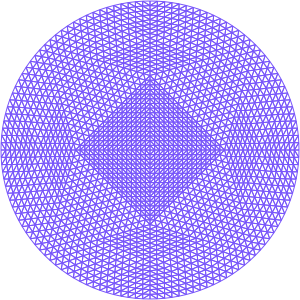

In [3]:

from scipy.sparse.linalg import splu  # for sparse matrices, 
# returns something like invA with LU decomp which can be applied with solve to solve Ax = b for x

from skfem.models.poisson import laplace, mass
from skfem.visuals.matplotlib import plot

mcirc= skfem.MeshTri.init_circle(5,smoothed=False)  # make a triangular mesh of the unit circle, number is refinement level
mcirc # show the mesh

In [5]:
# Reaction parts of differential equations for 
# three different types of different Reaction diffusion equations
# u,v are scalar fields, alpha, beta could be numbers or arrays with same dimension as fields
# rdtype is a string specifying the model
def Reaction(u,v,alpha,beta,rdtype):
    if (rdtype == 'FN'):  # FitzHugh Nagumo model
        Ru,Rv=R_FN(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Br'):  # Brusellator model
        Ru,Rv= R_Br(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'GS'):  # Gray-Scott model http://www.mrob.com/pub/comp/xmorphia/index.html
        Ru,Rv = R_GS(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Ba'):   # Barkley model 
        epsilon = 0.02  # choosing this value
        Ru,Rv = R_Ba(u,v,alpha,beta,epsilon)
        return Ru,Rv
    if (rdtype == 'Heat'):  # Heat equation 
        n = len(u)
        Ru = np.zeros(n); Rv = np.zeros(n)
        return Ru,Rv
    print('invalid reaction type')

#The FitzHugh-Nagumo Reaction Diffusion Model
# example: Du, Dv, alpha, beta = 1, 10, 0.1, 1, dt=0.01, dx = 1
def R_FN(u,v,alpha,beta): 
    Ru =  u - u**3 - v + alpha 
    Rv = (u - v)*beta
    return Ru,Rv
    
# Brusselator Reaction Diffusion model
# example: Du, Dv, alpha, beta = 2, 22, 5, 9 # dt=0.005, dx=1
# u = alpha, v = beta/alpha is a fixed point of R
def R_Br(u,v,alpha,beta): 
    Ru = alpha - (beta+1)*u + (u**2)*v    
    Rv = beta*u - (u**2)*v
    return Ru,Rv

# The Gray-Scott Reaction Diffusion model
# alpha is feed rate for u and kills v, beta is kill or drain rate for v
# example: Du = 0.2, Dv = Du/2, alpha = 0.037 and beta = 0.06 , dx=1
def R_GS(u,v,alpha,beta): 
    Ru =  -u*(v**2) + alpha*(1-u) 
    Rv =  u*(v**2) -(alpha+ beta)*v
    return Ru,Rv

# the Barkley model 
# http://www.scholarpedia.org/article/Barkley_model
# example epsilon=0.02, alpha = 0.75, beta = 0.02, domain = 200, dt = 0.01
def R_Ba(u,v,alpha,beta,epsilon): 
    Ru =  (1/epsilon)*u*(1-u)*(u - (v + beta)/alpha) 
    Rv =  u-v
    return Ru,Rv

In [7]:
# display u,v fields 
# calls skfem's plot routine 
def disp(mesh,u,v,basis,t):
    fig,axarr = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)
    ax0 = axarr[0]; ax1 = axarr[1]
    ax0.set_aspect('equal'); ax1.set_aspect('equal')
    ax_j0 = plot(mesh, u[basis.nodal_dofs.flatten()], shading='gouraud', ax = ax0)
    ax_j1 = plot(mesh, v[basis.nodal_dofs.flatten()], shading='gouraud', ax = ax1)
    fig = ax0.get_figure()
    field0 = ax0.get_children()[0]  # vertex-based temperature-colour
    field1 = ax1.get_children()[0]  # vertex-based temperature-colour
    fig.colorbar(field0,shrink=0.7)
    fig.colorbar(field1,shrink=0.7)
    title = ax0.set_title(f'u,  $t$ = {t:.3f}')
    title = ax1.set_title(f'v')


In [11]:
# split integrator, crank nicholson for the diffusion parts and simply adding in the 
# function terms by hand afterwards with a first order forward euler scheme
# do a single timestep, return u,v fields and time 
# requires globals: alpha, beta, rdtype, dt, backsolve_1, backsolve_2, B_1, B_2, D_u, D_v, bdofs, u_nb, v_nb 
def one_step(t,u,v):
    t += dt
    Ru,Rv = Reaction(u,v,alpha,beta,rdtype)
    u = backsolve_1(B_1 @ u + Bint_1)      # here we add the boundary term !
    v = backsolve_2(B_2 @ v + Bint_2)  
    u += Ru*dt  # add nonlinear parts 
    v += Rv*dt
    return t,u,v

In [13]:
element = skfem.ElementTriP1()  # or ElementTriP2?  a triangular element
basis = skfem.Basis(mcirc, element)
fbasis = skfem.FacetBasis(mcirc,element)  # facet basis in case we want to a non-zero Neumann condition 
#bdofs = basis.get_dofs()
#bdofs.flatten()

D_u  = 1.6e-3  #diffusion coefficients 
D_v = D_u*11
dt = .005    # timestep 

@skfem.LinearForm
def rhs(v,_):
    return 1.0 * v

L_1 = D_u * skfem.asm(laplace, basis)   # Laplacian for u field 
L_2 = D_v * skfem.asm(laplace, basis)   # Laplacian for v field 
M = skfem.asm(mass, basis)  # mass matrix (sizes of triangles) 

#L0, M0 = penalize(L, M, D=basis.get_dofs())  # sets boundary to zero Dirichlet boundary 
#L0=L;  #M0=M;
# ACQ otherwise gives von Neuman boundary condition!!!!!! 

theta = 0.5                     # Crank–Nicolson algorithm for a diffusion PDE
A_1 = M + theta * L_1 * dt
B_1 = M - (1 - theta) * L_1 * dt  

A_2 = M + theta * L_2 * dt
B_2 = M - (1 - theta) * L_2 * dt

backsolve_1 = splu(A_1.T).solve  # .T as splu prefers CSC which is a sparse matrix format (compressed sparse column)
backsolve_2 = splu(A_2.T).solve
# backsolve(B @ u) gives A^-1 (B u) but with LU decomp
#   solve for x such that Ax = Bu computed using LU decomp of A
# see https://en.wikipedia.org/wiki/LU_decomposition and 
# https://docs.scipy.org/doc/scipy-1.14.0/reference/generated/scipy.sparse.linalg.splu.html

# trying to make operators for the boundary integral 
u_nb = -2e-5  # normal components of slopes for Neumann BC regions 
v_nb = -0e-8
Bint_1 = skfem.asm(rhs,fbasis) *dt * D_u * u_nb
Bint_2 = skfem.asm(rhs,fbasis) *dt * D_v * v_nb

In [15]:
# make random initial conditions for u,v fields 
nnodes = len(basis.doflocs[0])
u0 = basis.zeros()
u_init = np.random.random(len(u0))*0.05
v_init = np.random.random(len(u0))*0.05


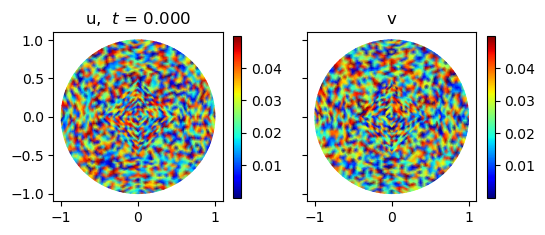

In [19]:
# show initial conditions 
t=0
disp(mcirc,u_init,v_init,basis,t)

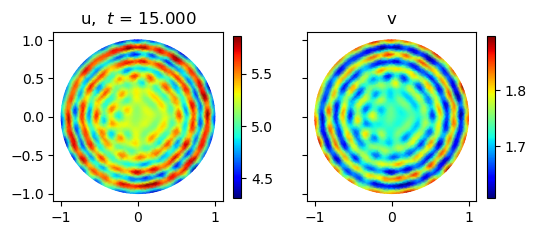

In [21]:
u = u_init; v = v_init; t=0; 
rdtype = 'Br'
alpha = 5.2; beta = 9.  # choose some nice Brusselator params
for i in range(3000):
    t, u, v = one_step(t,u,v)  
disp(mcirc,u,v,basis,t)

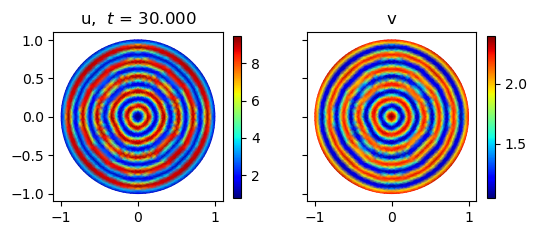

In [23]:
for i in range(3000):
    t, u, v = one_step(t,u,v)  
disp(mcirc,u,v,basis,t)